![title](img/pcanet.png)

0. все изображения привести к виду (m, m) 

1. Пусть у нас N изображений каждая (m, m). Вытаскиваем из одного изображения патчи размера $(k_a, k_a)$ вокруг каждого пикселя со stride = 1 на $a$ той итерации. 

2. Центрируем патчи: для каждого патча вычисляем среднее и вычитаем из каждого элемента патча среднее значение, для i-того изображения:
$\overline{X_i} = [\overline{x_1}, ..., \overline{x_N}] \subset \mathbb{R}^{k^2 x m^2}$

3. Проделываем это для N обучающих изображений: $X = [\overline{X_1}, ..., \overline{X_N}] \subset \mathbb{R}^{k^2 x Nm^2}$

4. для $ XX^T$ находим L **первых собственных векторов**, каждый из которых имеет размерность $ \mathbb{R}^{k^2}$, после этого делаем reshape до $ \mathbb{R}^{k x k}$ и получаем L искомых фильтров

## Я не использовал POOL слои совсем, но в перспективе можно попробовать!

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Импорт нужных библиотек

In [ ]:
import torch.nn.functional as F
from sklearn.decomposition import IncrementalPCA
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import torch
from torchvision import transforms, models, datasets

import random

## Класс PCANet

In [0]:
class PCANet(torch.nn.Module):
    def __init__(self, num_filters: list, filters_sizes: list, batch_size=256):
        super(PCANet, self).__init__()
        self.params = {
            'num_filters': num_filters,
            'filters_sizes': filters_sizes,
        }
        self.W_1 = None
        self.W_2 = None
        # размер in_features=30250 подбирался из дебага, но вообще говоря можно просчитать
        self.fc = torch.nn.Linear(30250, 2, bias=True)
        # self.act1 = torch.nn.ReLU()
        # self.fc2 = torch.nn.Linear(100, 2, bias=True)
        self.batch_size = batch_size

    def forward(self, x):
        x = F.conv2d(x, self.W_1)
        N1, C1, H1, W1 = x.shape

        x = F.conv2d(x, self.W_2)
        N, C, H, W = x.shape

        x_flat = x.view(N, C * H * W)

        x_flat = self.fc(x_flat)
        # x_flat = self.act1(x_flat)
        # x_flat = self.fc2(x_flat)
        return x_flat
            
    @staticmethod        
    def _extract_image_patches(imgs: torch.Tensor, filter_size, stride=1, remove_mean=True):
        # imgs.shape = (N, C, H, W) -> (N, 1, H, W) 
        # так должно быть, но сюда могут прийти не grayscale изображения первого шага, а со второго
        # на котором применено L1 фильтров -> L1 каналов
        N, n_channels, H, W = imgs.shape
        
        if n_channels > 1:
            # изображение вида (N, C, H, W) - N C-канальных изображений
            # приводим к виду (N*C, 1, H, W) - N*C одно-канальных изображений
            imgs = imgs.view(-1, 1, H, W)
        print('images shape', imgs.shape)
            
        k = filter_size
        patches = torch.nn.functional.unfold(imgs, k, padding=k//2) # (N, k^2, H*W)
        print('patches_shape, ', patches.shape)
        print('should be patches shape, ', (imgs.shape[0], k**2, H*W))
        
        if remove_mean:
            patches -= patches.mean(dim=1, keepdim=True) # последнее измерение - количество патчей
        
        print('filter_size', k)
        X = patches.view(k**2, -1) # (k^2, N*H*W)

        return X
    
    def _convolve(self, imgs: torch.Tensor, filter_bank: torch.Tensor) -> torch.Tensor:
        weight = filter_bank
        output = F.conv2d(imgs, weight) #, padding=padding)
        return output
    
    def _first_stage(self, imgs: torch.Tensor, train: bool) -> torch.Tensor:
        # (N, C, H, W) image
        # (train_size, 1, H, W) - grayscale
        assert imgs.dim() == 4 and imgs.nelement() > 0

        print('PCANet first stage...')

        if train:
            # достаем все патчи из всех N изображений
            filter_size1 = self.params['filters_sizes'][0]
            X = self._extract_image_patches(
                imgs, filter_size1)
            
            n_filters = self.params['num_filters'][0]
            
            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters, batch_size=self.batch_size)
            self.W_1 = torch.FloatTensor(eigenvectors).view(n_filters, 1, filter_size1, filter_size1)
         
        I = self._convolve(imgs, self.W_1)  # (N, 1, H, W) * (L1, k1, k1) -> (N, L1, H', W')
        return I
    
    @staticmethod
    def conv_output_size(w, filter_size, padding=0, stride=1):
        return int((w - filter_size + 2 * padding) / stride + 1)
    
    @staticmethod
    def get_pca_eigenvectors(X, n_components, batch_size=100):
        ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
        print('pca fitting ...')
        ipca.fit(X @ X.t())
        eigenvectors = ipca.components_
        print('eigenvectors shape:', eigenvectors.shape)
        return eigenvectors
        
    def _second_stage(self, I: torch.Tensor, train):
        print('PCANet second stage...')
        # I: (N, L1, H, W)
        if train:
            N, L1, H, W = I.shape
            filter_size2 = self.params['filters_sizes'][1]
            n_filters2 = self.params['num_filters'][1]
            n_filters1 = self.params['num_filters'][0]
            
            H_new = self.conv_output_size(I.shape[2], filter_size2)
            W_new = self.conv_output_size(I.shape[3], filter_size2)
            
            X = self._extract_image_patches(I, filter_size2)
            print('X_SHAPE ', X.shape)
            eigenvectors = self.get_pca_eigenvectors(X, n_components=n_filters2, batch_size=self.batch_size)
            W_2 = torch.FloatTensor(eigenvectors).view(n_filters2, 1, filter_size2, filter_size2) # (L2, 1, k2, k2)
            self.W_2 = W_2.repeat(1, n_filters1, 1, 1) # (L2, L1, k2, k2) - повторяет L1 раз для конкретного l из L2
        return self._convolve(I, self.W_2)
    
    def run(self, images):
        # Создаем фильтры
        # images: (N, 1, H, W)
        I = self._first_stage(images, train=True)
        print("I ", I.shape)
        II = self._second_stage(I, train=True)
        N, C, H, W = II.shape
        # self.fc = torch.nn.Linear(H * W, 2, bias=True)
        
        

In [112]:
# CONV1: 5 фильтров 3x3
# CONV2: 10 фильтров 8x8
net = PCANet([5, 10], [3, 8])
net.params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net = net.to(device)

cuda:0


In [97]:
data_root = 'drive/My Drive/dl_noise_classification/data/'
train_dir = 'train'
val_dir = 'val'
class_names = ['awgn', 'bayer']

train_dir = os.path.join(data_root, train_dir)
val_dir = os.path.join(data_root, val_dir)

train_dir

'drive/My Drive/dl_noise_classification/data/train'

In [0]:
SEED = 1235

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

num_epochs = 1000
batch_size = 150
lr = 1e-6

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [100]:
train_transforms = transforms.Compose([
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


train_dataset = datasets.ImageFolder(train_dir, train_transforms)
val_dataset = datasets.ImageFolder(val_dir, val_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)

all_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_size, shuffle=False, num_workers=batch_size)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

all_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_size, shuffle=False, num_workers=batch_size)

print("TRAIN_SIZE: {}\n VAL_SIZE: {}".format(train_size, val_size))

TRAIN_SIZE: 750
 VAL_SIZE: 150


#### Загрузить сразу все картинки из train и val в тензоры по памяти хуже, но по скорости обучения в несколько десятков раз выше, так как очень много времени тратится на загрузку изображений из dataloader. 

1000 эпох обучается примерно 30 секунд.

Поэтому ниже я выгружаю все TRAIN_SIZE и VAL_SIZE сразу в тензоры

In [101]:
print('all val data loading ...')
val_data = next(iter(all_val))
print('all train data loading ...')
train_data = next(iter(all_train))

all val data loading ...
all train data loading ...


In [0]:
from time import time

val_loss = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)

val_acc = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)


def train_model(model, loss, optimizer, scheduler, num_epochs):
    
    # запустить процесс создания фильтров, если только их нет
    if model.W_1 is None or model.W_2 is None:
        print('Making filters....')
        t_start = time()
        model.run(train_data[0])
        print('TIME: ', time() - t_start)

    model.W_1 = model.W_1.to(device)
    model.W_2 = model.W_2.to(device)

    for epoch in range(num_epochs):

        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                data = train_data
                model.train()  # training mode
                history_acc = train_acc
                history_loss = train_loss
            else:
                data = val_data
                model.eval()   # evaluate mode (dropout + bn)
                history_acc = val_acc
                history_loss = val_loss

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward and backward
            with torch.set_grad_enabled(phase=='train'):
                preds = model(inputs)
                loss_value = loss(preds, labels)
                preds_class = preds.argmax(dim=1)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()

            # statistics
            running_loss += loss_value.cpu().item()
            running_acc += (preds_class.cpu() == labels.cpu().data).float().mean()
            
            epoch_loss = running_loss
            epoch_acc = running_acc
            history_acc[epoch] = epoch_acc
            history_loss[epoch] = epoch_loss

            # запоминаем модель по лоссу

            print('{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc), flush=True)

In [134]:
# Аккуратнее с логами, возможно это уже не первый запуск train_model с теми же параметрами
train_model(net, loss, optimizer, None, num_epochs=num_epochs)

Streaming output truncated to the last 5000 lines.
train Loss: 0.4826 Acc: 0.9253

val Loss: 0.4848 Acc: 0.9067

Epoch 1/999:
train Loss: 0.4826 Acc: 0.9253

val Loss: 0.4847 Acc: 0.9067

Epoch 2/999:
train Loss: 0.4826 Acc: 0.9253

val Loss: 0.4847 Acc: 0.9067

Epoch 3/999:
train Loss: 0.4825 Acc: 0.9253

val Loss: 0.4847 Acc: 0.9067

Epoch 4/999:
train Loss: 0.4825 Acc: 0.9267

val Loss: 0.4846 Acc: 0.9067

Epoch 5/999:
train Loss: 0.4825 Acc: 0.9267

val Loss: 0.4846 Acc: 0.9067

Epoch 6/999:
train Loss: 0.4825 Acc: 0.9267

val Loss: 0.4846 Acc: 0.9067

Epoch 7/999:
train Loss: 0.4824 Acc: 0.9267

val Loss: 0.4846 Acc: 0.9067

Epoch 8/999:
train Loss: 0.4824 Acc: 0.9267

val Loss: 0.4845 Acc: 0.9067

Epoch 9/999:
train Loss: 0.4824 Acc: 0.9267

val Loss: 0.4845 Acc: 0.9067

Epoch 10/999:
train Loss: 0.4824 Acc: 0.9267

val Loss: 0.4845 Acc: 0.9067

Epoch 11/999:
train Loss: 0.4823 Acc: 0.9267

val Loss: 0.4845 Acc: 0.9067

Epoch 12/999:
train Loss: 0.4823 Acc: 0.9267

val Loss: 0.48

### Почему не сразу 10000 эпох?: при разных SEED могло получаться так, что при таком же lr обучения не было вообще, лоссы и точности не менялись, но при этом все дико подвисало и приходилось долго ждать, пока все 10000 эпох закончатся

## Первая 1000 эпох

Text(0.5, 1.0, 'loss')

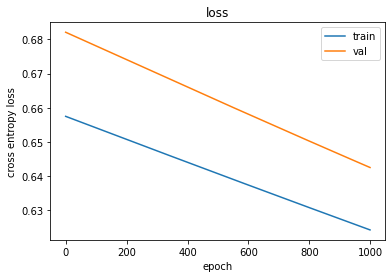

In [117]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

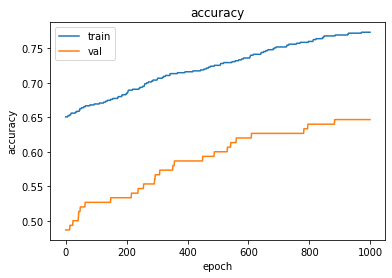

In [118]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')

## 1000-2000 эпохи

Text(0.5, 1.0, 'loss')

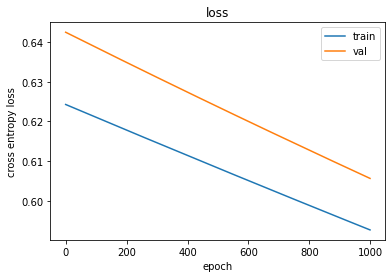

In [120]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

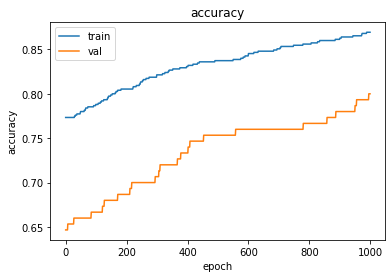

In [121]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')

## 2000-3000 эпохи

Text(0.5, 1.0, 'loss')

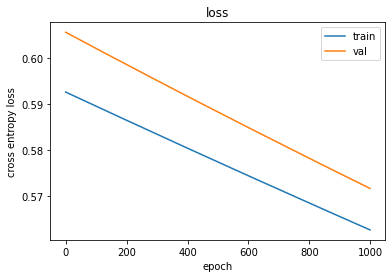

In [123]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

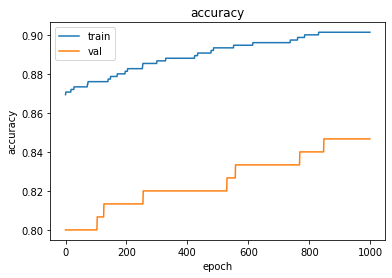

In [124]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')

## 3000-4000 эпохи

Text(0.5, 1.0, 'loss')

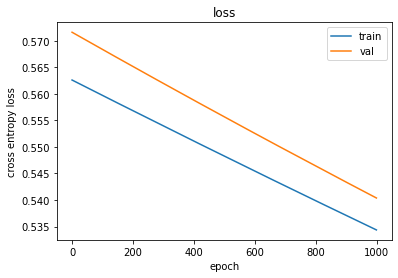

In [126]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

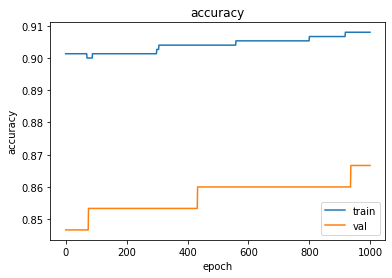

In [127]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')

## 4000-5000 эпохи

Text(0.5, 1.0, 'loss')

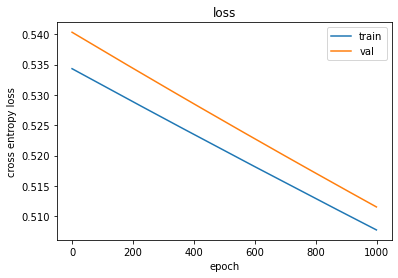

In [129]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

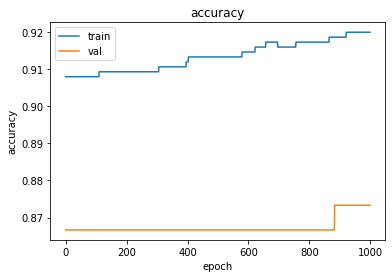

In [130]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')

## 5000-6000 эпохи

Text(0.5, 1.0, 'loss')

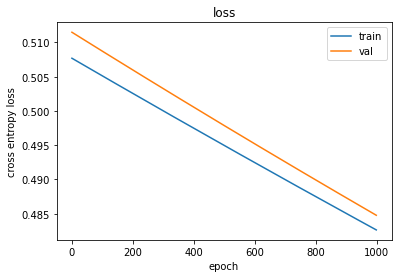

In [132]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

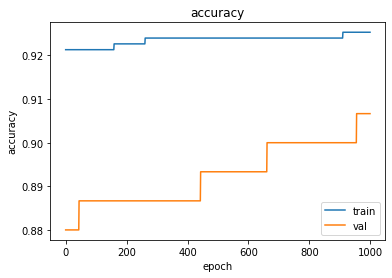

In [133]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')

## 7000-8000 эпохи

Text(0.5, 1.0, 'loss')

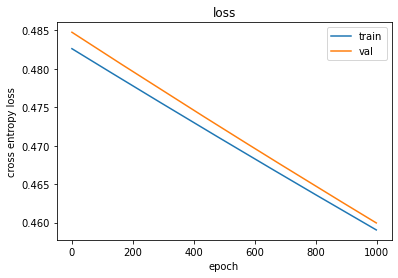

In [135]:
# Loss
plt.plot(range(num_epochs), train_loss, val_loss)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.title('loss')

Text(0.5, 1.0, 'accuracy')

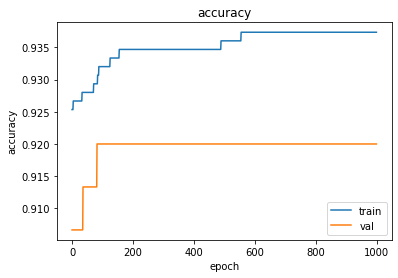

In [136]:
# accuracy
plt.plot(range(num_epochs), train_acc, val_acc)
plt.legend(['train', 'val'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy')